In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/Diabetes dataset'

In [ ]:
!ls "/content/drive/MyDrive/Diabetes dataset"

diabetic_data.csv  IDS_mapping.csv


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:

diabetic_data = pd.read_csv(os.path.join(folder_path, 'diabetic_data.csv'))
ids_mapping = pd.read_csv(os.path.join(folder_path, 'IDS_mapping.csv'))

print("Shape of diabetic_data:", diabetic_data.shape)
print(diabetic_data.head())

print("\nShape of ids_mapping:", ids_mapping.shape)
print(ids_mapping.head())

Shape of diabetic_data: (101766, 50)
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...    

In [ ]:
print(diabetic_data['admission_type_id'].dtype)
print(ids_mapping['admission_type_id'].dtype)

int64
object


In [ ]:
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype(str)
ids_mapping['admission_type_id'] = ids_mapping['admission_type_id'].astype(str)

In [ ]:
diabetic_data = diabetic_data.merge(ids_mapping, on='admission_type_id', how='left')

In [ ]:

print((diabetic_data == '?').sum())


diabetic_data.replace('?', pd.NA, inplace=True)


encounter_id                     0
patient_nbr                      0
race                          6819
gender                           0
age                              0
weight                      295707
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                  120768
medical_specialty           149847
num_lab_procedures               0
num_procedures                   0
num_medications                  0
number_outpatient                0
number_emergency                 0
number_inpatient                 0
diag_1                          63
diag_2                        1074
diag_3                        4269
number_diagnoses                 0
max_glu_serum                    0
A1Cresult                        0
metformin                        0
repaglinide                      0
nateglinide                      0
chlorpropamide                   0
glimepiride         

In [ ]:
print(diabetic_data['race'].value_counts())
print(diabetic_data['gender'].value_counts())
print(diabetic_data['age'].value_counts())

race
Caucasian          228297
AfricanAmerican     57630
Hispanic             6111
Other                4518
Asian                1923
Name: count, dtype: int64
gender
Female             164124
Male               141165
Unknown/Invalid         9
Name: count, dtype: int64
age
[70-80)     78204
[60-70)     67449
[50-60)     51768
[80-90)     51591
[40-50)     29055
[30-40)     11325
[90-100)     8379
[20-30)      4971
[10-20)      2073
[0-10)        483
Name: count, dtype: int64


In [ ]:
diabetic_data.drop(columns=['encounter_id', 'patient_nbr'], inplace=True, errors='ignore')

In [ ]:
print(diabetic_data.columns.tolist())

['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'description']


In [ ]:

print(diabetic_data.duplicated().sum())

diabetic_data.drop_duplicates(inplace=True)

0


In [ ]:
def detect_outliers_iqr(df, columns):
    outlier_flags = pd.DataFrame(index=df.index)

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_flags[f'{col}_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)


    outlier_flags['is_outlier_row'] = outlier_flags.any(axis=1)

    return pd.concat([df, outlier_flags], axis=1)

In [ ]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before_rows = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after_rows = df.shape[0]
        print(f"Removed {before_rows - after_rows} outliers from {col}")
    return df

In [ ]:
num_cols = diabetic_data.select_dtypes(include=[np.number]).columns.tolist()

diabetic_data = detect_outliers_iqr(diabetic_data, num_cols)

print("Total rows with at least one outlier:", diabetic_data['is_outlier_row'].sum())

print(diabetic_data[diabetic_data['is_outlier_row']].head())

diabetic_data = remove_outliers_iqr(diabetic_data, num_cols)

diabetic_data.drop(columns=[col for col in diabetic_data.columns if '_outlier' in col or col == 'is_outlier_row'], inplace=True)

Total rows with at least one outlier: 134070
              race  gender      age weight admission_type_id  \
0        Caucasian  Female   [0-10)   <NA>                 6   
1        Caucasian  Female   [0-10)   <NA>                 6   
2        Caucasian  Female   [0-10)   <NA>                 6   
6  AfricanAmerican  Female  [20-30)   <NA>                 1   
7  AfricanAmerican  Female  [20-30)   <NA>                 1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1       <NA>   
1                        25                    1                 1       <NA>   
2                        25                    1                 1       <NA>   
6                         1                    7                 2       <NA>   
7                         1                    7                 2       <NA>   

          medical_specialty  ...  admission_source_id_outlier  \
0  Pediatrics-Endo

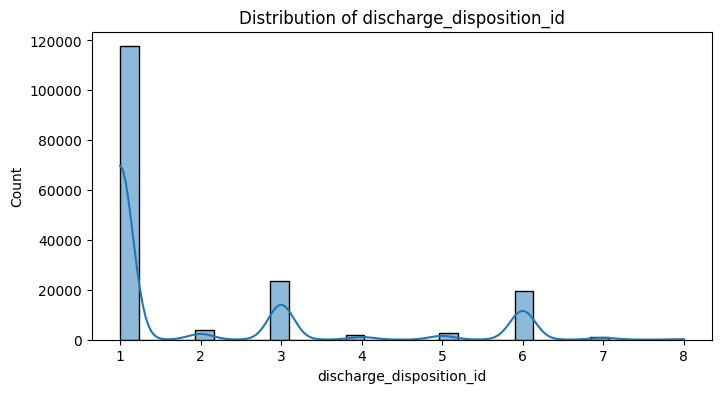

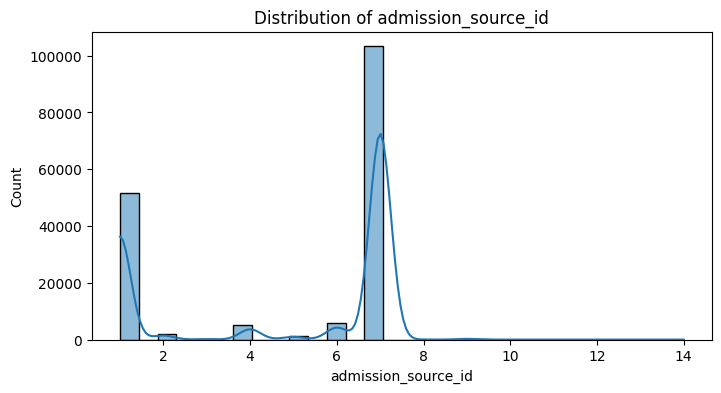

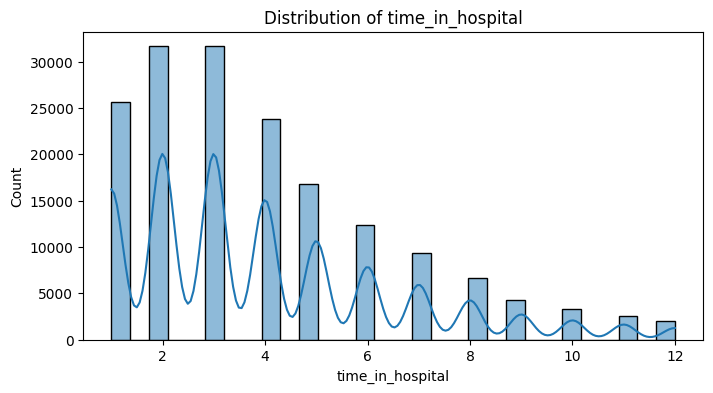

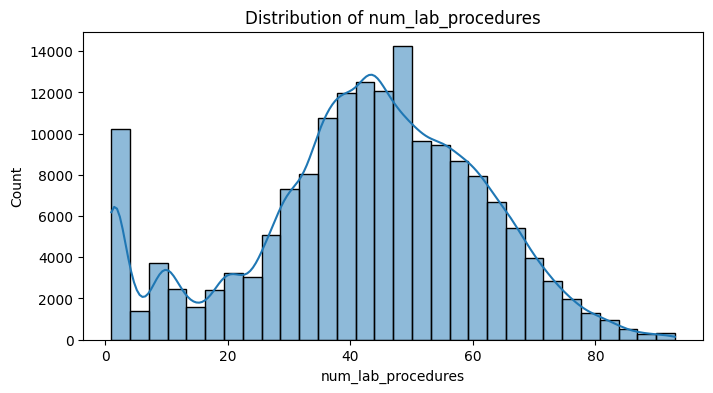

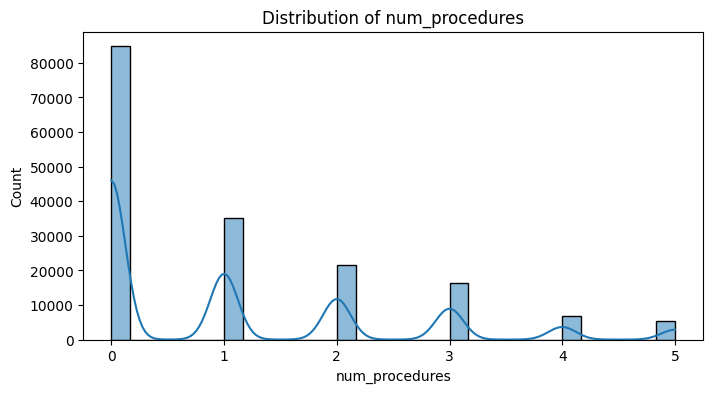

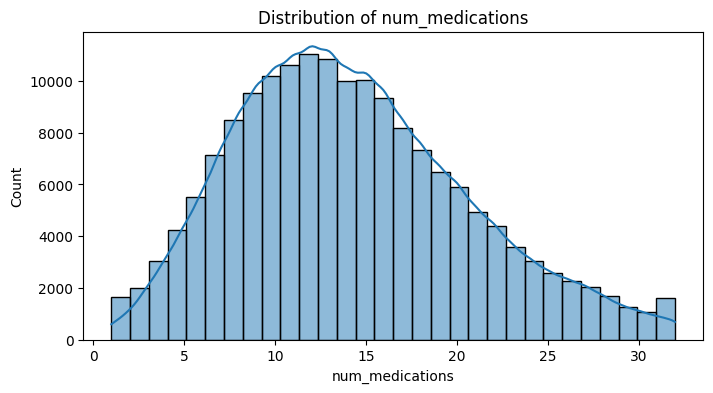

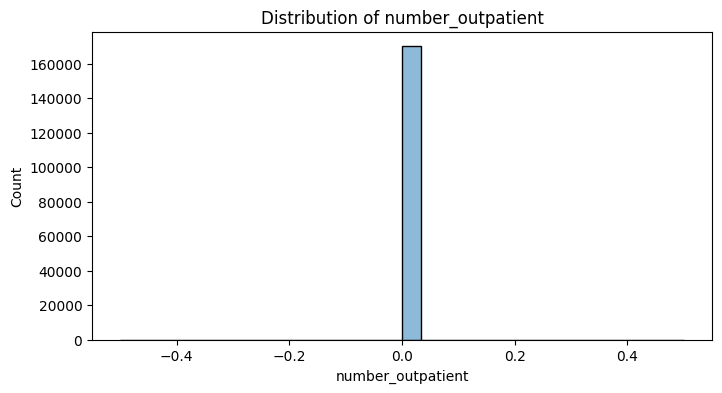

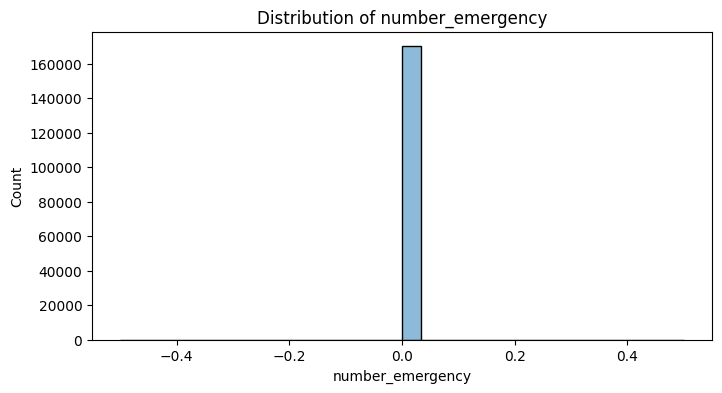

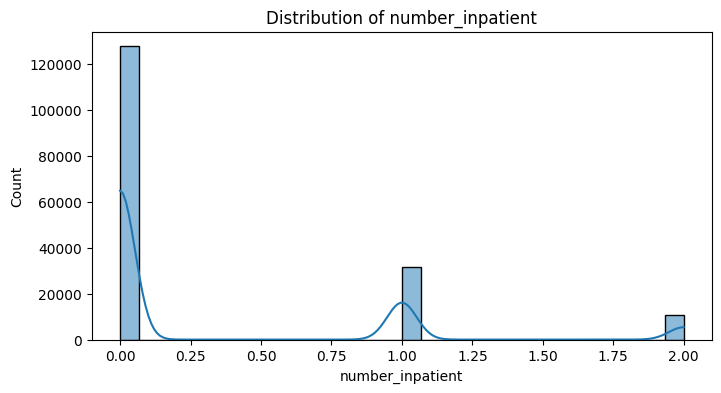

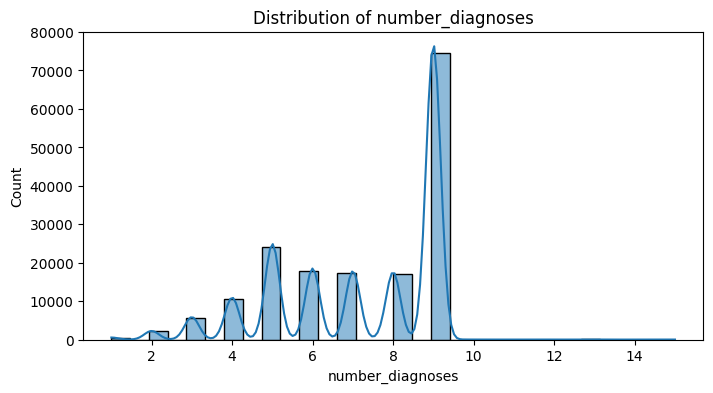

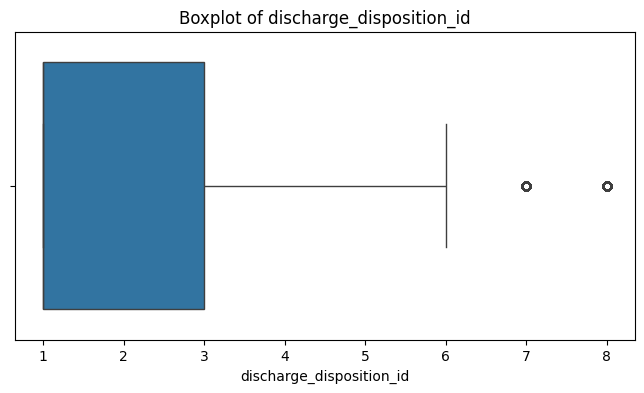

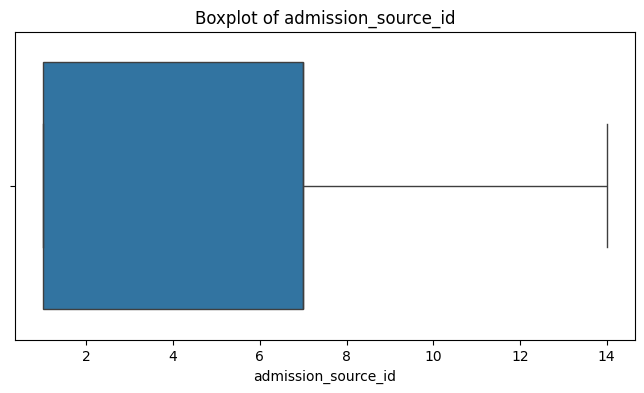

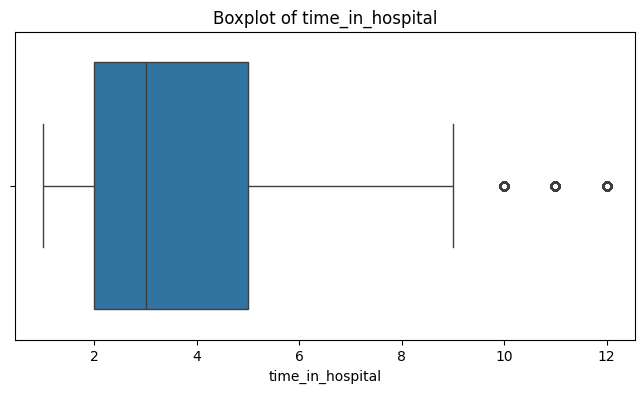

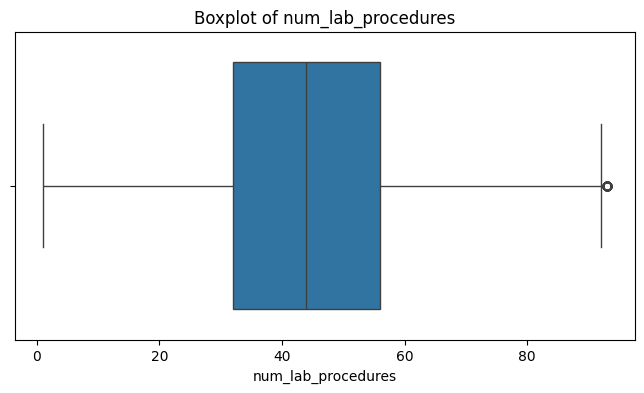

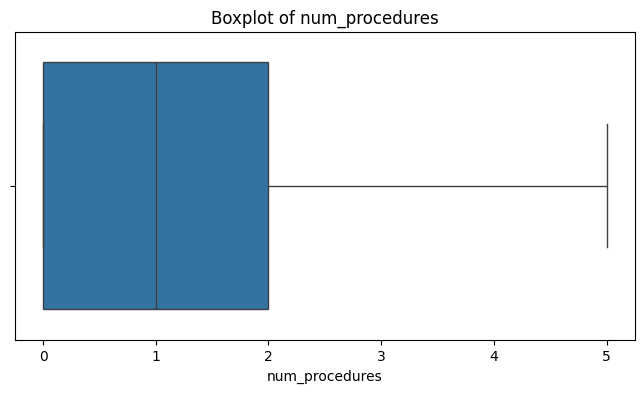

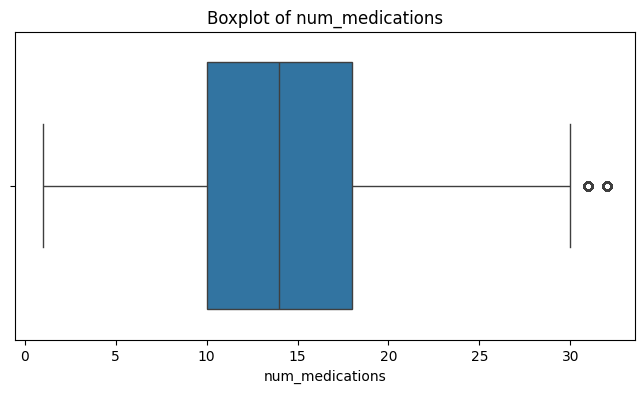

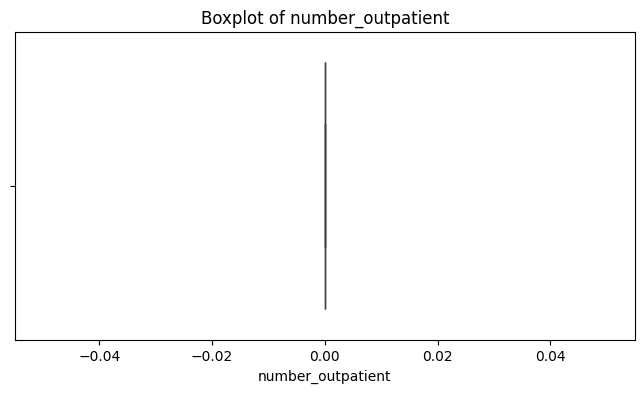

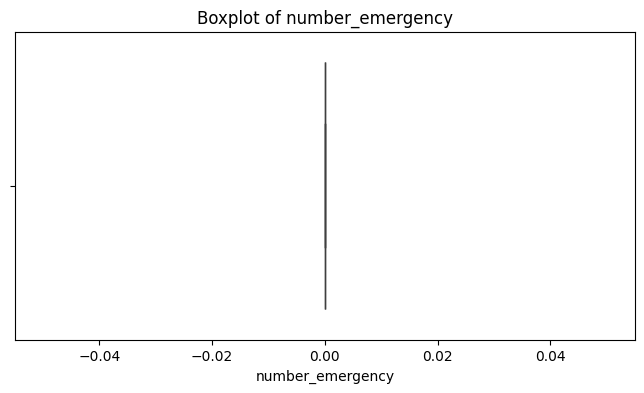

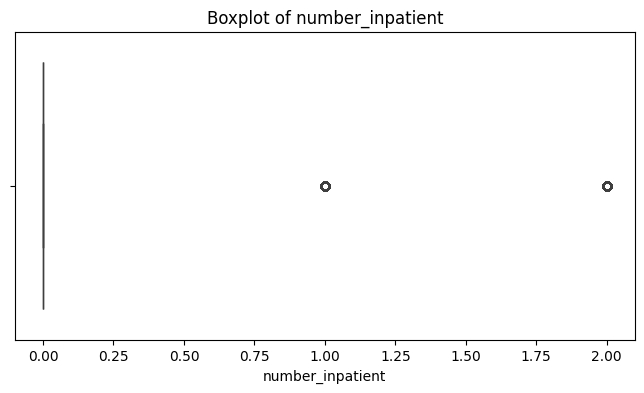

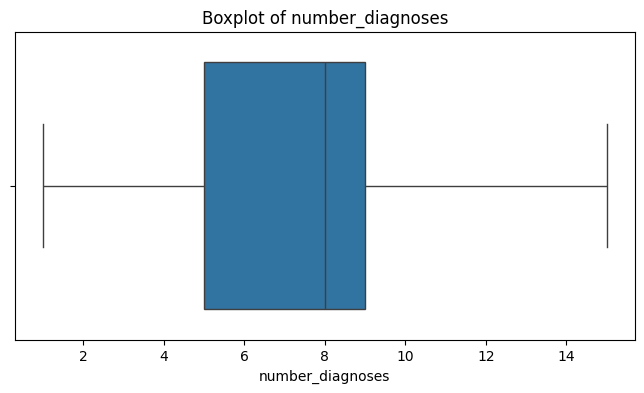

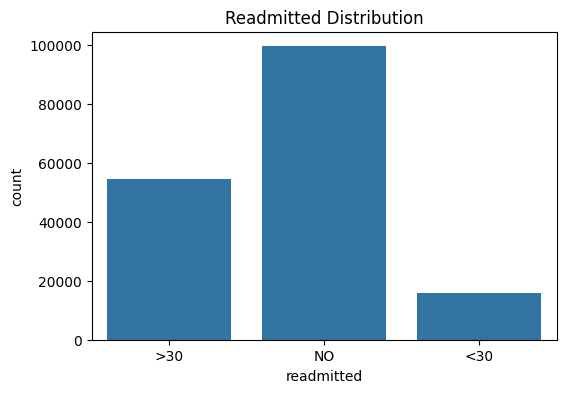

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(diabetic_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=diabetic_data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=diabetic_data, x='readmitted')
plt.title('Readmitted Distribution')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
diabetic_data[num_cols] = scaler.fit_transform(diabetic_data[num_cols])

In [41]:
diabetic_data['readmitted'] = diabetic_data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [44]:
diabetic_data = pd.get_dummies(diabetic_data, columns=cat_cols, drop_first=True)

In [45]:
from sklearn.model_selection import train_test_split

X = diabetic_data.drop('readmitted', axis=1)
y = diabetic_data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Training Logistic Regression...

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     30861
           1       0.33      0.00      0.01      3141

    accuracy                           0.91     34002
   macro avg       0.62      0.50      0.48     34002
weighted avg       0.85      0.91      0.86     34002

ROC AUC Score: 0.6767


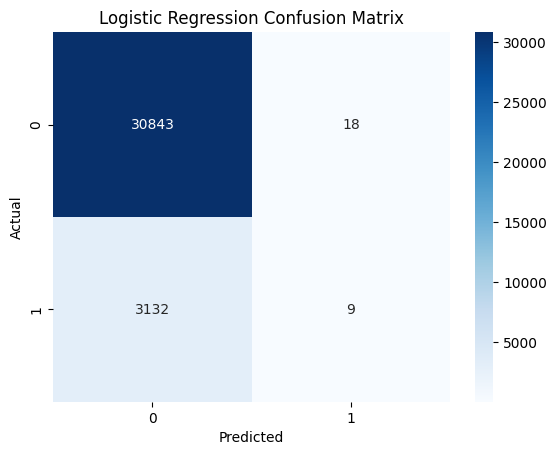


Training Random Forest...

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30861
           1       1.00      0.81      0.89      3141

    accuracy                           0.98     34002
   macro avg       0.99      0.90      0.94     34002
weighted avg       0.98      0.98      0.98     34002

ROC AUC Score: 0.9969


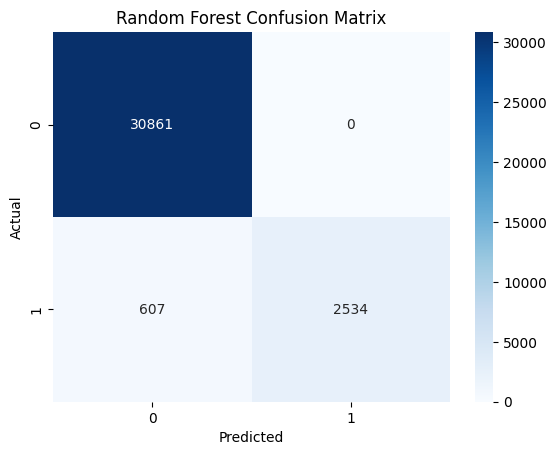


Training Linear SVM...

Linear SVM Performance:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     30861
           1       0.53      0.02      0.04      3141

    accuracy                           0.91     34002
   macro avg       0.72      0.51      0.49     34002
weighted avg       0.87      0.91      0.87     34002

ROC AUC Score: 0.6825


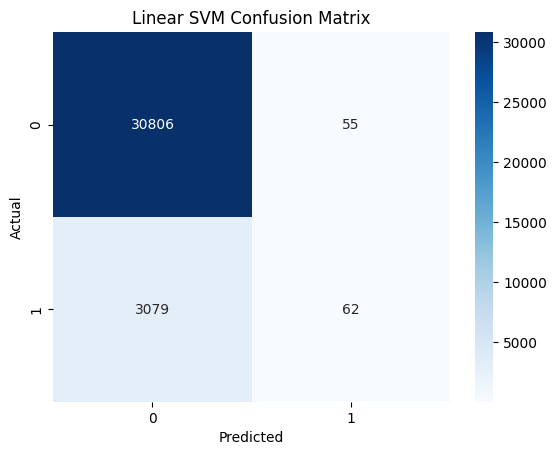


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:51:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     30861
           1       0.90      0.02      0.04      3141

    accuracy                           0.91     34002
   macro avg       0.91      0.51      0.50     34002
weighted avg       0.91      0.91      0.87     34002

ROC AUC Score: 0.7547


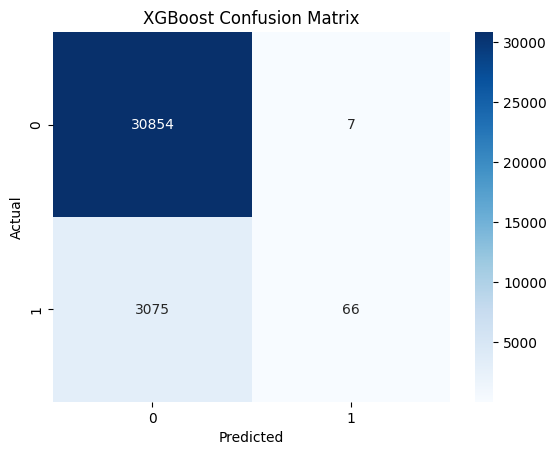

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

X_train.columns = X_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
X_test.columns = X_test.columns.str.replace(r'[\[\]<>]', '', regex=True)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Linear SVM': CalibratedClassifierCV(LinearSVC(max_iter=1000)),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Use predict_proba if available
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_prob = model.decision_function(X_test)

    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()